<a href="https://colab.research.google.com/github/eto-ai/rikai/notebooks/UncertaintySampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Sampling

[Active Learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)) is one such technique that helps ML practitioners intelligently select high-value raw data to be labeled to maximize model improvement. Studies have shown that this type of learning strategy can produce significant improvement in model accuracy for the same number of samples; or require significantly fewer examples to reach the same accuracy.


In [1]:
!python -V
!nvidia-smi
!java --version

Python 3.9.7
Sat Jan 29 15:08:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:07:00.0 Off |                  N/A |
| 41%   48C    P8     6W / 280W |    179MiB / 24186MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                           

In [ ]:
!pip install rikai[mlflow,pytorch]
!pip install seaborn

In [ ]:
import mlflow
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from rikai.spark.utils import get_default_jar_version

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

rikai_version = get_default_jar_version(use_snapshot=False)

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
spark = (
    SparkSession
    .builder
    .config("spark.jars.packages", f"ai.eto:rikai_2.12:0.1.0")
    .config(
        "spark.sql.extensions",
        "ai.eto.rikai.sql.spark.RikaiSparkSessionExtensions",
    )
    .config(
        "spark.rikai.sql.ml.registry.mlflow.tracking_uri",
        MLFLOW_TRACKING_URI,
    )
    .config("spark.executor.memory", "4g")  # Runnable on Colab
    .config("spark.driver.memory", "1g")
    .master("local[2]")
    .getOrCreate()
);

In [4]:
# From https://pytorch.org/vision/0.11/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

@udf
def coco_name(idx: int) -> str:
  return COCO_INSTANCE_CATEGORY_NAMES[idx]

spark.udf.register("coco_name", coco_name)

# Create a category table
spark.createDataFrame(
    [{"label": idx, "name": name} for idx, name in enumerate(COCO_INSTANCE_CATEGORY_NAMES)]
).createOrReplaceTempView("cats")

# Preparing data

We use Coco's evaluation dataset to prepare a [Rikai](https://github.com/eto-ai/rikai) dataset. 

Note that, we only use eval set because it can fit into Google Colab's disk quota. 


In [ ]:
from pathlib import Path

coco_dir = Path("./coco")
if not coco_dir.exists() and True:
  !mkdir -p coco
  !wget http://images.cocodataset.org/zips/val2017.zip -O coco/val2017.zip
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco/annotations.zip
  !cd coco && find . -name '*.zip' -exec unzip -qq {} \; && rm *.zip

from rikai.contrib.datasets.coco import convert_instance

!rm -rf spark-warehouse/
df = convert_instance(
    spark, 
    "coco/annotations/instances_val2017.json",
    "coco/val2017",
)
df.write.mode("overwrite").save("datasets/coco")
df.createOrReplaceTempView("coco")

# Lets also create a COCO-1000 dataset for faster demo purpose
df.limit(2000).repartition(4).createOrReplaceTempView("coco_1k")

In [6]:
spark.sql("SHOW TABLES").show()
spark.sql("SELECT COUNT(*) FROM coco").show()

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
|        |     cats|       true|
|        |     coco|       true|
|        |  coco_1k|       true|
+--------+---------+-----------+



22/01/29 15:08:30 WARN TaskSetManager: Stage 6 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


+--------+
|count(1)|
+--------+
|    4952|
+--------+



In [7]:
spark.sql("SELECT * FROM coco").printSchema()


root
 |-- date_captured: string (nullable = true)
 |-- width: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- file_name: string (nullable = true)
 |-- image: image (nullable = true)
 |-- image_id: integer (nullable = true)
 |-- annotations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- image_id: integer (nullable = true)
 |    |    |-- area: double (nullable = true)
 |    |    |-- label_id: integer (nullable = true)
 |    |    |-- ann_id: long (nullable = true)
 |    |    |-- bbox: box2d (nullable = true)
 |    |    |-- segmentation: mask (nullable = true)
 |    |    |-- supercategory: string (nullable = true)
 |    |    |-- label: string (nullable = true)



# Register Models

We use a pre-trained [PyTorch SSD object detection model](https://pytorch.org/vision/0.11/models.html#object-detection-instance-segmentation-and-person-keypoint-detection). Rikai also comes with a customized model (`SSDClassScoresExtractor`) that uses SSD to extract detection classes and scores. 

We use [Mlflow](https://mlflow.org/) as a model registry to serve models into Rikai SQL-ML engine. Once the registration is done, you can list the models in the Rikai model catalog:

In [ ]:
import rikai
from torchvision.models.detection.ssd import ssd300_vgg16
from rikai.contrib.torch.inspect.ssd import SSDClassScoresExtractor
from rikai.contrib.torch.detections import OUTPUT_SCHEMA

ssd = ssd300_vgg16(pretrained=True)
class_scores_extractor = SSDClassScoresExtractor(ssd, topk_candidates=90)

print(OUTPUT_SCHEMA)

with mlflow.start_run():
    rikai.mlflow.pytorch.log_model(
        ssd, 
        "model", 
        OUTPUT_SCHEMA,
        pre_processing="rikai.contrib.torch.transforms.ssd.pre_processing",
        post_processing="rikai.contrib.torch.transforms.ssd.post_processing",
        registered_model_name="ssd"
    )
with mlflow.start_run():
    rikai.mlflow.pytorch.log_model(
        class_scores_extractor,
        "model_scores",
        SSDClassScoresExtractor.SCHEMA,
        pre_processing="rikai.contrib.torch.inspect.ssd.class_scores_extractor_pre_processing",
        post_processing="rikai.contrib.torch.inspect.ssd.class_scores_extractor_post_processing",
        registered_model_name="class_scores"
    )

We then load the models from `mlflow` registry to make them available to use in Spark SQL. 

In [9]:
spark.sql("""
  CREATE OR REPLACE MODEL ssd 
  OPTIONS (batch_size=64, num_workers=4, min_score=0.3) 
  USING 'mlflow:/ssd'""")
spark.sql("""
  CREATE OR REPLACE MODEL class_scores 
  OPTIONS (batch_size=64, num_workers=4) 
  USING 'mlflow:/class_scores'""")
spark.sql("SHOW MODELS").show()

+------------+------+--------------------+--------------------+
|        name|flavor|                 uri|             options|
+------------+------+--------------------+--------------------+
|         ssd|      |         mlflow:/ssd|{"batch_size":"64...|
|class_scores|      |mlflow:/class_scores|{"batch_size":"64...|
+------------+------+--------------------+--------------------+



# Least Confidence

**Least Confidence** looks for predicted labels with the lowest degree of confidence

$$ 1 - P(y_1 | x) $$

This strategy identifies the predictions with the lowest confidence score. Using Rikai, this is a simple SQL statement that looks like the following:

In [10]:
least_confident_df = spark.sql("""
SELECT  /*+ REPARTITION(200) */ 
  image_id, image, explode(ML_PREDICT(ssd, image)) AS ssd 
FROM coco_1k
ORDER BY ssd.score ASC
LIMIT 1000
""")
least_confident_df.cache()

DataFrame[image_id: int, image: ImageType, ssd: struct<box:box2d,score:float,label_id:int>]

We get a PySpark DataFrame once we execute this Spark SQL query and we can take a quick look at the results. Rikai is integrated with Jupyter so that it's easy to visualize your images and annotations without having to mess with low level PIL/OpenCV APIs.

In [11]:
from rikai.viz import Text
for row in least_confident_df.take(3):
    text = COCO_INSTANCE_CATEGORY_NAMES[row.ssd.label_id]
    display(row.image 
        | row.ssd.box@{"color": "red", "width": 3} 
        | Text(f"{text} | {row.ssd.score:.3f}", 
               (row.ssd.box.xmin + 2, row.ssd.box.ymax + 2))@{"color": "red"}
    )

22/01/29 15:08:40 WARN TaskSetManager: Stage 11 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.
/home/lei/miniconda3/envs/rikai/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/lei/miniconda3/envs/rikai/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/lei/miniconda3/envs/rikai/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (T

Draw(style({'color': 'red', 'width': 3}))

Draw(style({'color': 'red', 'width': 3}))

Draw(style({'color': 'red', 'width': 3}))

# Least Margin of Confidence

**Margin of Confidence** looks for training examples with the lowest difference between most likely and second most likely labels. Intuitively, it gives insights into where the model is confused the most.

$$ P(y_1 | x) - P(y_2 | x) $$

This strategy finds predictions where the model has a hard time distinguishing between the top two classes. Here, we use Rikai's `SSDClassScoresExtractors` model to extract the classes (label) and scores for the top candidates from each bounding box:

In [12]:
margin_df = spark.sql("""
SELECT 
  image_id, image, detection,
  detection.scores[0] - detection.scores[1] as margin FROM (
    SELECT 
      image_id, 
      image, 
      explode(ML_PREDICT(class_scores, image)) AS detection 
    FROM coco_1k
) ORDER BY margin
LIMIT 10000
""")
margin_df.persist()
margin_df.createOrReplaceTempView("least_margin")


Again, let's inspect the query results:

In [13]:
for row in margin_df.take(3):
    label1 = COCO_INSTANCE_CATEGORY_NAMES[row.detection.label_ids[0]]
    label2 = COCO_INSTANCE_CATEGORY_NAMES[row.detection.label_ids[1]]
    text = f"{label1} - {label2}\n{row.margin:0.10f}"
    box = row.detection.box
    print(box)
    display(
        row.image 
        | box@{"color": "red", "width": 3} 
        | Text(text, (box.xmin, box.ymax + 2))@{"color": "red"}
    )

22/01/29 15:10:13 WARN TaskSetManager: Stage 18 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.
/home/lei/miniconda3/envs/rikai/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/lei/miniconda3/envs/rikai/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Box2d(xmin=73.05917358398438, ymin=209.89321899414062, xmax=141.5962371826172, ymax=294.2609558105469)


Draw(style({'color': 'red', 'width': 3}))

Box2d(xmin=154.48191833496094, ymin=0.9953994750976562, xmax=189.10792541503906, ymax=30.06791877746582)


Draw(style({'color': 'red', 'width': 3}))

Box2d(xmin=154.48191833496094, ymin=0.9953994750976562, xmax=189.10792541503906, ymax=30.06791877746582)


Draw(style({'color': 'red', 'width': 3}))

# Entropy

**Entropy** observing the average level of uncertainty over all the labels.

$$ \frac{-\sum_{i=1}^{n}P(y_i | x)log_{2}P(y_i | x)}{log_2{n}}$$

It is a measure of the amount of information in data. The higher value the entropy is, the more similar all the values are. While margin of confidence takes into account the top two classes, entropy takes into account all predicted classes. For active learning using uncertainty sampling, we're looking for predictions with the highest entropy.

In [14]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from scipy.stats import entropy as scipyEntropy

@udf(returnType=FloatType())
def entropy(arr) -> float:
    """Calculate entropy over all scores"""
    return float(scipyEntropy(arr))

spark.udf.register("entropy", entropy)

<function __main__.entropy(arr) -> float>

In [15]:
entropy_df = spark.sql("""
SELECT image_id, image, detection, entropy(detection.scores) as entropy FROM (
    SELECT 
      image_id, 
      image,
      explode(ML_PREDICT(class_scores, image)) AS detection 
    FROM coco_1k
) ORDER BY entropy DESC
LIMIT 1000
""")
entropy_df.cache()
entropy_df.show()

22/01/29 15:12:30 WARN TaskSetManager: Stage 26 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+--------------------+---------+
|image_id|               image|           detection|  entropy|
+--------+--------------------+--------------------+---------+
|    1818|Image('coco/val20...|{Box2d(xmin=295.2...|4.1675296|
|  416330|Image('coco/val20...|{Box2d(xmin=180.4...|4.1614213|
|  560266|Image('coco/val20...|{Box2d(xmin=294.4...|4.1578226|
|   66926|Image('coco/val20...|{Box2d(xmin=0.0, ...|4.1131573|
|  416330|Image('coco/val20...|{Box2d(xmin=162.4...|4.1114154|
|  236730|Image('coco/val20...|{Box2d(xmin=292.5...|4.0928903|
|  127517|Image('coco/val20...|{Box2d(xmin=13.95...| 4.091193|
|  511398|Image('coco/val20...|{Box2d(xmin=0.733...|4.0902147|
|  127517|Image('coco/val20...|{Box2d(xmin=2.820...|4.0861125|
|  547519|Image('coco/val20...|{Box2d(xmin=263.6...| 4.080772|
|  255483|Image('coco/val20...|{Box2d(xmin=296.2...|4.0782504|
|  456292|Image('coco/val20...|{Box2d(xmin=206.4...|4.0779357|
|  407943|Image('coco/val20...|{Box2d(xmin=0.562...| 4.

In [16]:
first = entropy_df.first()
text = f"{COCO_INSTANCE_CATEGORY_NAMES[first.detection.label_ids[0]]}\n{first.entropy}"
box = first.detection.box
print(box)
(
    first.image 
    | box@{"color": "yellow", "width": 3} 
    | Text(text, (box.xmin, box.ymax))@{"color": "yellow"}
)

Box2d(xmin=295.2266540527344, ymin=293.4456481933594, xmax=300.0, ymax=300.0)


Draw(style({'color': 'yellow', 'width': 3}))

# Let's Analyze

Our analysis does not stop here. 
With these uncertainty sampling techniques, we can gain much more insights about our model and dataset.

We start with the question: "what classes get the official PyTorch SSD model confused the most?"

In [17]:
confused_label_df = spark.sql("""
  SELECT 
    coco_name(detection.label_ids[0]) as first_class,
    coco_name(detection.label_ids[1]) as second_class,
    count(image_id) as cnt,
    avg(margin) as avg_margin
  FROM least_margin
  GROUP BY detection.label_ids[0], detection.label_ids[1]
  SORT BY cnt DESC
  LIMIT 20
""")
confused_label_df.show()


+-----------+------------+---+--------------------+
|first_class|second_class|cnt|          avg_margin|
+-----------+------------+---+--------------------+
|      chair|      person|384|0.002099549031602995|
|     person|       chair|362|0.002084207552541768|
|       bird|       sheep|226|0.001905121508804...|
|     person|         car|192|0.002111577137839049|
|        car|      person|190|0.002086845241290...|
|      sheep|         cow|182|0.002249634970532...|
|      knife|        fork|164|0.001898048138927...|
|     remote|  cell phone|161|0.002110700499011863|
|     carrot|    broccoli|159|0.002068170975987454|
|        cow|       sheep|155|0.001984328953849...|
|      sheep|        bird|152|0.002204929095521...|
|   backpack|     handbag|152|0.002152346656657...|
|      knife|       spoon|149|0.002041609204630...|
|        cup|      bottle|138| 0.00225396950027325|
|       fork|       knife|133|0.002184224784150...|
|   broccoli|      carrot|132|0.002054252319574...|
|       kite

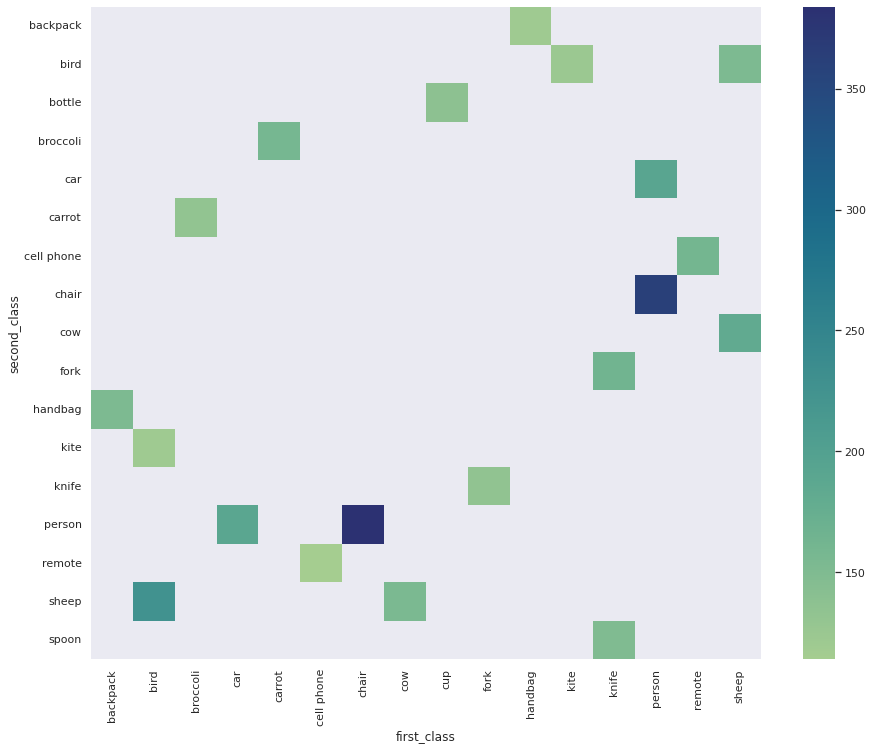

In [18]:
import seaborn

seaborn.set(rc = {'figure.figsize':(15,12), 'savefig.dpi': 300})

heatmap = confused_label_df.toPandas().set_index(['first_class', 'second_class']).cnt.unstack(0)
ax = seaborn.heatmap(heatmap, cmap="crest")

What a surprise, our model is highly likely to confuse between `person` and `chair`!! 

But if we dig deeper, we found that between `(remote, cell phone)` and `(sheep, cow)`, the `avg_margin`s are lower. 

We could not help to wonder: "*is it because the dataset has much more `person/chair`s than `remote/cellphone`s (a.k.a, imbalanced dataset)?*"

With Rikai, it is easy to verify this hyperthesis:

In [19]:
spark.sql("""
  SELECT 
    coco_name(detection.label_id) as label,
    count(detection.label_id) AS cnt 
  FROM (
    SELECT 
      explode(ML_PREDICT(ssd, image)) AS detection
    FROM coco_1k
  ) WHERE coco_name(detection.label_id) IN ('person', 'chair', 'remote', 'cell phone', 'sheep', 'cow')
  GROUP BY detection.label_id
  ORDER BY cnt DESC
""").toPandas()

22/01/29 15:14:46 WARN TaskSetManager: Stage 54 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


label   cnt
0      person  2630
1       chair   198
2       sheep   113
3         cow    67
4  cell phone    28
5      remote     9

Great, our hyperthesis has been proved: `person` has 60 times more instances than `cell phone` and `remote` combined!

While our field team is busy working on collecting more `cell phone` and `remote` data to be labeled,
we would like to understand why our model got confused between `person` and `chair` too!

Which extra dimensions in the dataset can give us more insights, we wonder? Let's try the size of bounding boxes (`area`):

In [20]:
person_area_pdf = spark.sql("""
SELECT box_area, count(*) AS cnt FROM (
    SELECT 
     CAST(area(detection.box) / 500 AS int) * 500 AS box_area
    FROM least_margin
    WHERE coco_name(detection.label_ids[0]) IN ('chair', 'person') 
      AND coco_name(detection.label_ids[1]) IN ('chair', 'person')
)
GROUP BY box_area
ORDER BY box_area
""").toPandas()

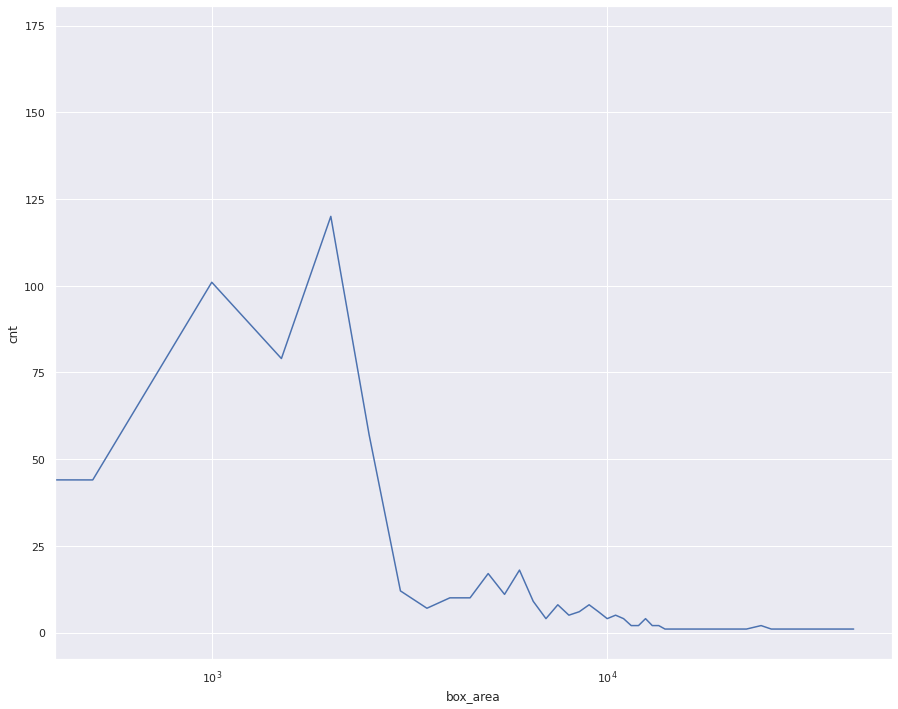

In [21]:
ax = seaborn.lineplot(data=person_area_pdf, x="box_area", y="cnt")
ax.set(xscale="log");

This time, it is not a surprise. Smaller (between $10^2$ and $10^4$ pixels) objects have less pixels, thus less features to compute in a CNN.


# Data Mining and Pre-Labelling

It is a pandemic (2022) and everybody works from home. Our field team does not have enough resources to collect enough data.
Can we mine high-value data from all the petabytes of data sitting in our data lake to improve our model performance NOW?
Let's find some new data for label, which satisfy:

 * Is `chair`, `remote` or `phone`
 * Box area is between $10^2$ to $10^4$ pixels
 * Has low confidence (`score < 0.7`)

In [22]:
spark.sql("""
SELECT image_id, image, detection.* FROM (
    SELECT image_id, image, explode(ML_PREDICT(ssd, image)) as detection FROM coco_1k
) WHERE 
    100 < area(detection.box) AND area(detection.box) < 10000 
    AND coco_name(detection.label_id) IN ('chair', 'remote', 'phone')
    AND detection.score < 0.7
""").show()

22/01/29 15:16:21 WARN TaskSetManager: Stage 86 contains a task of very large size (10079 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+--------------------+----------+--------+
|image_id|               image|                 box|     score|label_id|
+--------+--------------------+--------------------+----------+--------+
|  492758|Image('coco/val20...|Box2d(xmin=126.89...| 0.6669177|      62|
|  492758|Image('coco/val20...|Box2d(xmin=150.31...|0.44934303|      62|
|  492758|Image('coco/val20...|Box2d(xmin=2.0448...|0.40570477|      62|
|  492758|Image('coco/val20...|Box2d(xmin=201.53...|0.36356112|      62|
|  235836|Image('coco/val20...|Box2d(xmin=52.652...| 0.5879513|      62|
|  351810|Image('coco/val20...|Box2d(xmin=0.5508...|0.33497718|      62|
|  527784|Image('coco/val20...|Box2d(xmin=171.01...| 0.3510151|      62|
|  297562|Image('coco/val20...|Box2d(xmin=180.81...|0.38484576|      62|
|  171757|Image('coco/val20...|Box2d(xmin=137.60...|0.39326504|      62|
|  276285|Image('coco/val20...|Box2d(xmin=0.0, y...|0.33798766|      62|
|  276285|Image('coco/val20...|Box2d(xmin=255.40...

The obtained data can then send to the labeling or QA teams, with ***pre-labeled*** annotations. These pre-labeling techniques have demonstrated significant efficiency improvements in practice. These pre-labeling techniques have demostrated significant improvements in practice.

# Close the loop

As our examples have shown, even with a well-established public dataset (COCO) and a popular model (SSD, https://arxiv.org/abs/1512.02325), there are still plenty of interesting edge-cases and insights to be discovered. For real-world datasets in production AI where data quality tends to be much worse, active learning is an even more important tool to improve the quality of your models.

